In [1]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [2]:
def getrealconc(t,x,y,D):
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+4))
    if blobsize<1: blobsize=1
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 300*norm(0,blobsize).pdf(d)*norm(20,5).cdf(t)
    return [t,t+10,x,y],v

In [3]:
X = []
Y = []
D = 2.0
for x in np.linspace(10,90,7):
    for y in np.linspace(10,90,7):
        for t in np.linspace(0,60,7):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


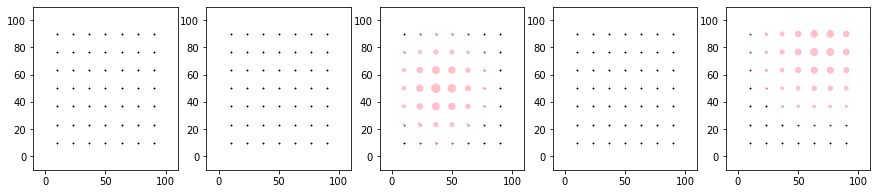

In [4]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [5]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10
boundary = ([-7.0, -10, -10], [77.0, 100, 100])
print(boundary)

([-7.0, -10, -10], [77.0, 100, 100])


In [24]:
np.random.seed(42)
#set up our model...
N_feat = 2197 #Number of features used to infer the source
#k = EQ(25, 1)
k = GaussianBases(25, 1)
res = [120,30,30]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
noiseSD = 0.001
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.05
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

mInfer.computeModelRegressors(Nparticles=40) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

#Normal (negative and positive...)
Nsamps = 5
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)
print("Actual number of features: %d" % k.N_feat)

Initialising particles...
Computing SS...
Inverting SS...
Computing meanZ
Done


<ipython-input-24-87f730db83df>:24: RuntimeWarning: covariance is not positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
Actual number of features: 2197


In [7]:
#Non-negative...
r = 15
nonNegFrom = mInfer.boundary[0]
nonNegTo = mInfer.boundary[1]
Xnonneg = np.array(np.meshgrid(np.linspace(nonNegFrom[0],nonNegTo[0],r+2)[1:-1],np.linspace(nonNegFrom[1],nonNegTo[1],r+2)[1:-1],np.linspace(nonNegFrom[2],nonNegTo[2],r+2)[1:-1]))
Xnonneg = Xnonneg.reshape(3,r**3).T

from advectionGP.constraints import NonNegConstraint
nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=30,burnin=30,jitter=1e-6,verbose=True,usecaching=False)
Zs_nonneg = nnc.sample(Nsamps)

sources_nonneg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs_nonneg])
sourcemean_nonneg = np.mean(sources_nonneg,0)
sourcevar_nonneg = np.var(sources_nonneg,0)

Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
W not passed to findstartpoint, searching full space
Finding Start Point
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
  179/  180 [samples]
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...


In [26]:
#nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=1000,jitter=0,verbose=False,usecaching=True,burnin=1000)
#nnc.check_convergence(Nchains=4)
#1.25 with GaussianBases.

In [27]:
scaleby = [10,3,3]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]] #20x10x10

concmean,concvar,conc = mInfer.computeConcentration(Zs=Zs,Nsamps=1,Nparticles=10,interpolateSource=True,coords=coords.transpose([1,2,3,0]))
concmean_nonneg,concvar_nonneg,conc_nonneg = mInfer.computeConcentration(Zs=Zs_nonneg,Nsamps=1,Nparticles=10,interpolateSource=True,coords=coords.transpose([1,2,3,0]))

Initialising particles...
(12, 10, 10, 3)
(10, 12, 10, 10, 3)
Particle shape:
(10, 12, 10, 10, 3)
Diffusing particles...
Initialising particles...
(12, 10, 10, 3)
(10, 12, 10, 10, 3)
Particle shape:
(10, 12, 10, 10, 3)
Diffusing particles...
cache miss, computing source from phi...


IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [28]:
#to make computing the real concentration quicker, just use a subset of positions
gridps = mInfer.coords.transpose([1,2,3,0]).copy()

gridps = gridps[::scaleby[0],::scaleby[1],::scaleby[2]]
realconc = np.zeros(gridps.shape[:-1])

for i in np.ndindex(gridps.shape[:3]):
    if (i[1]==0) & (i[2]==0): print("%d of %d" % (i[0],gridps.shape[0]))
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

0 of 12
1 of 12


<ipython-input-2-5a0038e08320>:3: RuntimeWarning: invalid value encountered in sqrt
  blobsize = np.sqrt(2*2*D*(t+4))


2 of 12
3 of 12
4 of 12
5 of 12
6 of 12
7 of 12
8 of 12
9 of 12
10 of 12
11 of 12


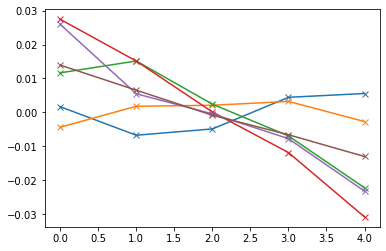

In [29]:
plt.plot(sources_nonneg[:,10,15,::5]-np.mean(sources_nonneg[:,10,15,::5],0),'x-')

In [30]:
np.unique(mInfer.getGridCoord(Xnonneg)[:,0])

array([  7,  15,  22,  30,  37,  45,  52,  60,  67,  75,  82,  90,  97,
       105, 112])

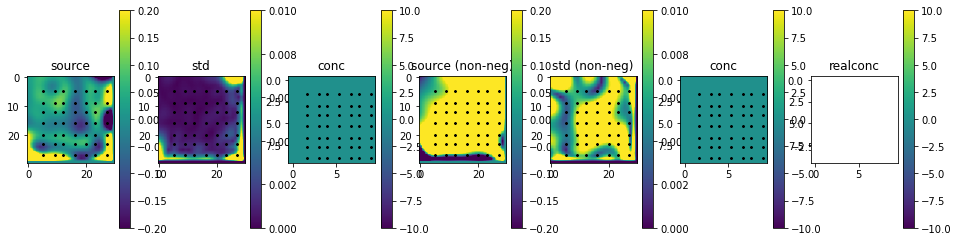

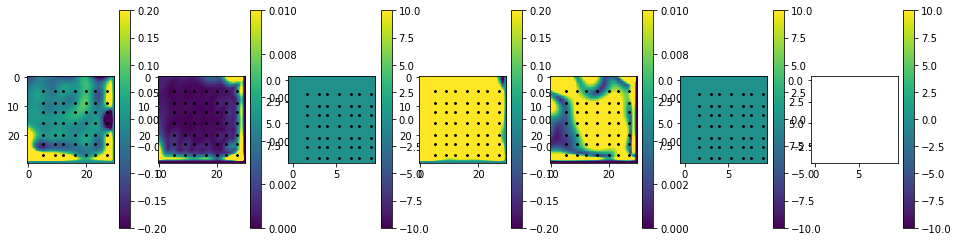

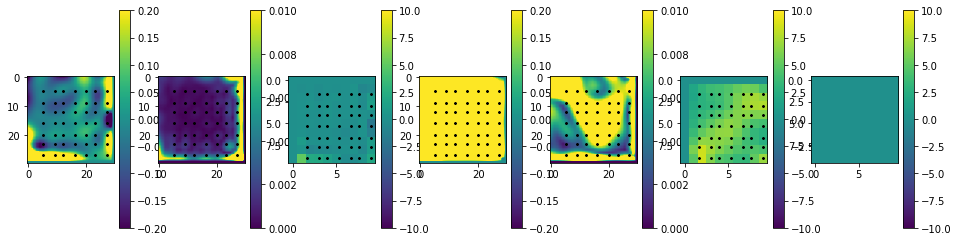

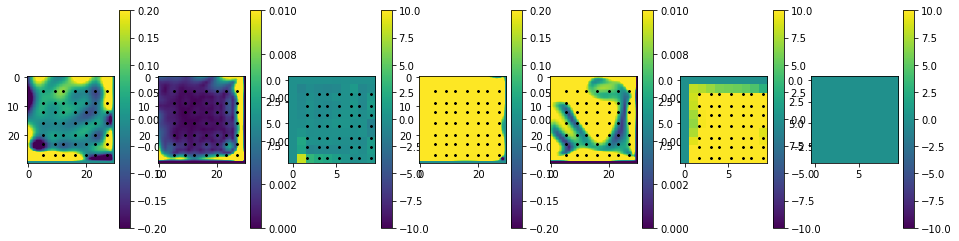

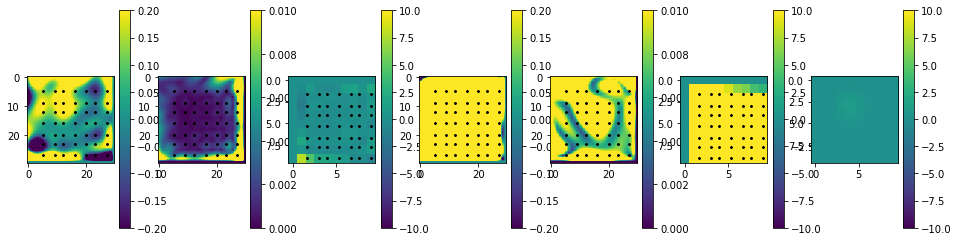

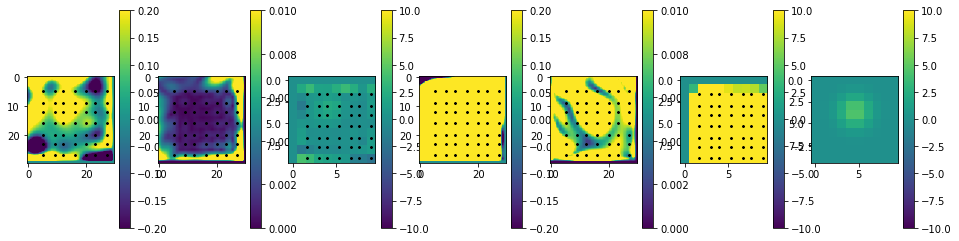

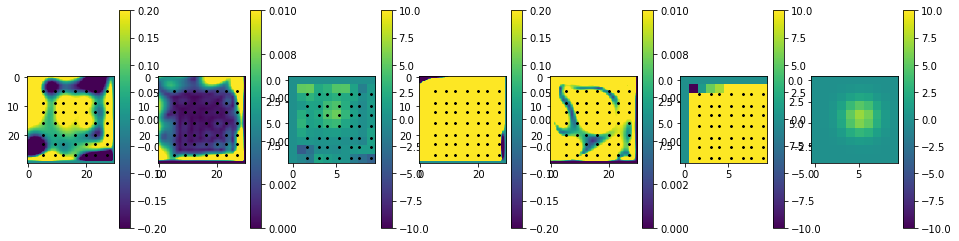

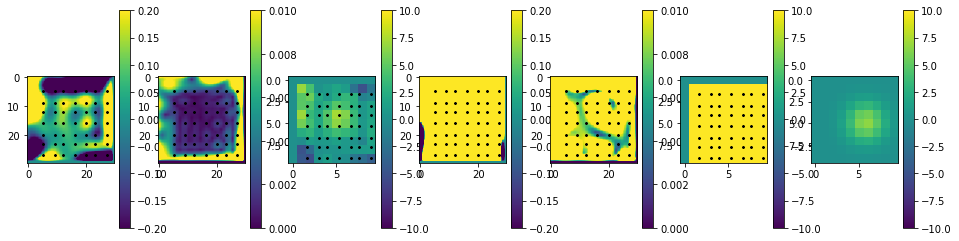

In [31]:
slice_coord=11
gridX = mInfer.getGridCoord(X[:,1:])
plot1d = False
for tsamp in np.array([ 0,  8, 17, 26, 35, 43, 52, 61]):
    plt.figure(figsize=[16,4])
    plt.subplot(1,7,1)
    if tsamp==0: plt.title('source')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources[:,tsamp,slice_coord,:].T,'k-',alpha=0.5)
        plt.ylim([-.2,0.2])
        plt.grid()
    else:
        plt.imshow(sourcemean[tsamp,:,:])
        plt.colorbar()
        plt.clim([-0.2,0.2])
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,2)
    if tsamp==0: plt.title('std')
    if plot1d:    
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],np.sqrt(sourcevar[tsamp,slice_coord,:]))
        plt.grid()
    else:
        plt.imshow(np.sqrt(sourcevar[tsamp,:,:]))
        plt.clim([0,0.01])
        plt.colorbar()
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('conc')
    if plot1d:    
        plt.plot(concmean[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.grid()
    else:
        plt.imshow(concmean[tsamp//scaleby[0],:,:])
        plt.clim([-10,10])
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')
    
    
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('source (non-neg)')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean_nonneg[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources_nonneg[:,tsamp,slice_coord,:].T,'k-',alpha=0.5)
        plt.vlines(Xnonneg[:,2],0,-0.01)
        plt.ylim([-.2,0.2])
        plt.grid()
    else:
        plt.imshow(sourcemean_nonneg[tsamp,:,:])    
        plt.colorbar()
        plt.clim([-0.2,0.2])
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('std (non-neg)')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],np.sqrt(sourcevar_nonneg[tsamp,slice_coord,:]))
        plt.grid()
    else:
        plt.imshow(np.sqrt(sourcevar_nonneg[tsamp,:,:]))
        plt.colorbar()
        plt.clim([0,0.01])
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')

    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc')
    if plot1d:    
        plt.plot(concmean_nonneg[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.grid()
    else:
        plt.imshow(concmean_nonneg[tsamp//scaleby[0],:,:])
        plt.clim([-10,10])
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')
        
    plt.subplot(1,7,7)
    if tsamp==0: plt.title('realconc')
    if plot1d:    
        plt.plot(realconc[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.grid()
    else:
        plt.imshow(realconc[tsamp//scaleby[0],:,:])   
        plt.clim([-10,10])
        plt.colorbar()

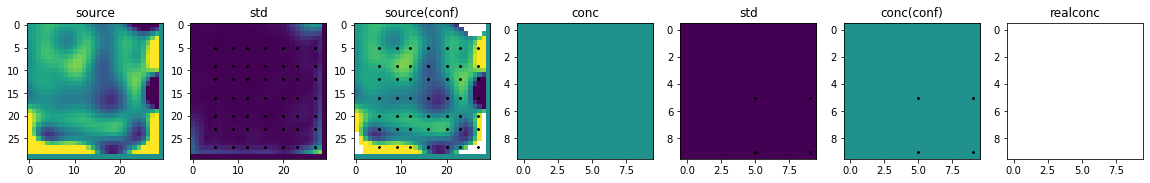

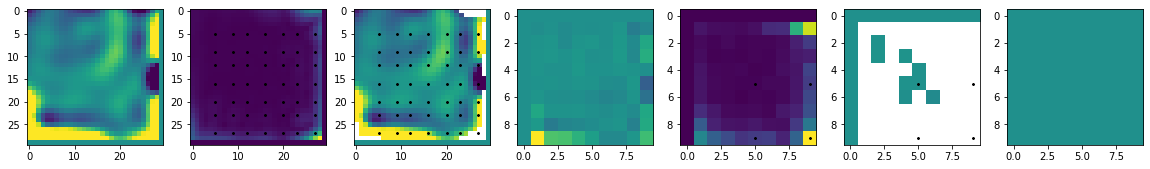

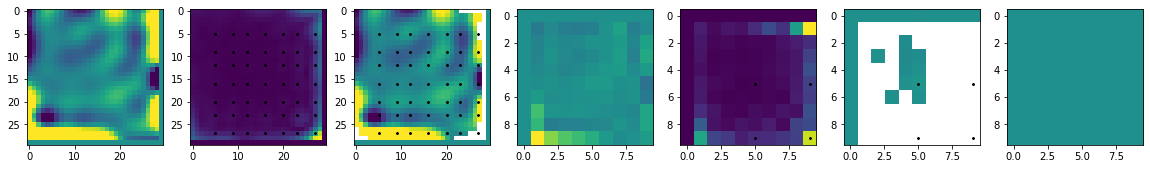

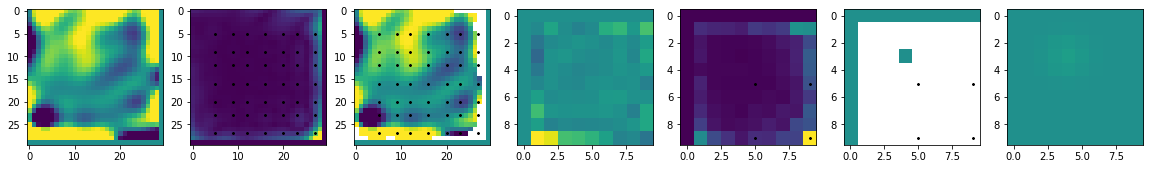

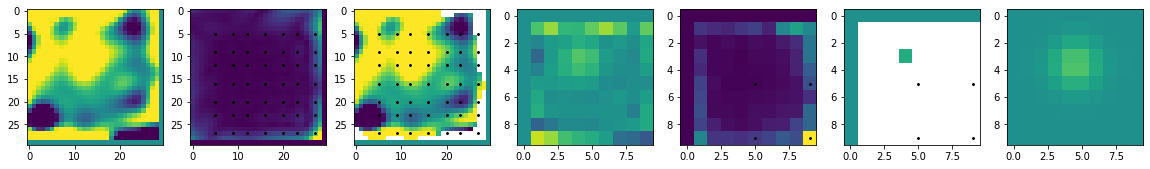

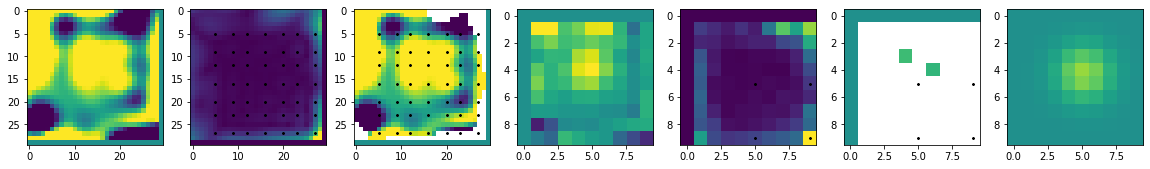

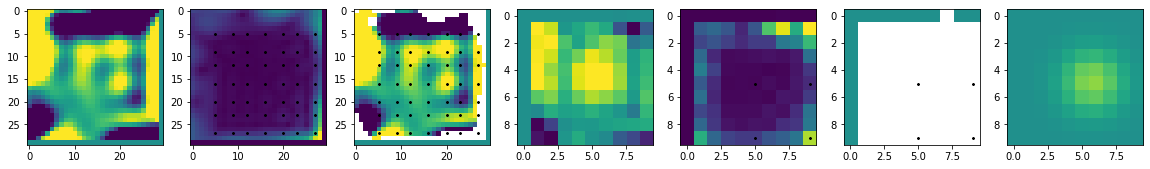

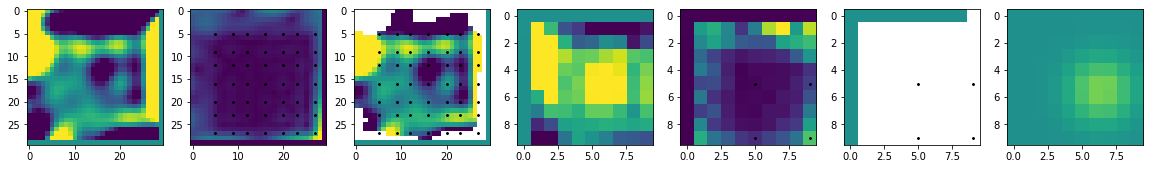

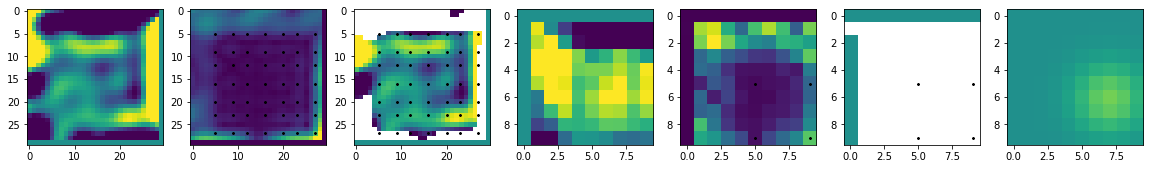

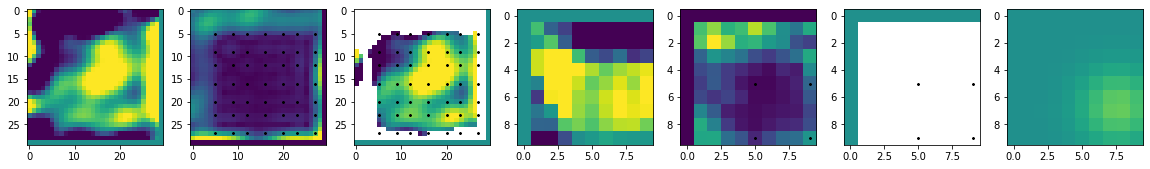

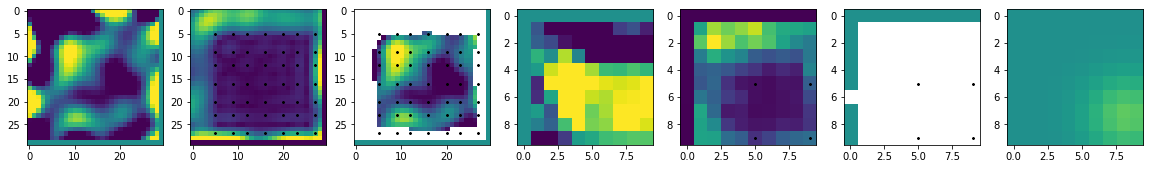

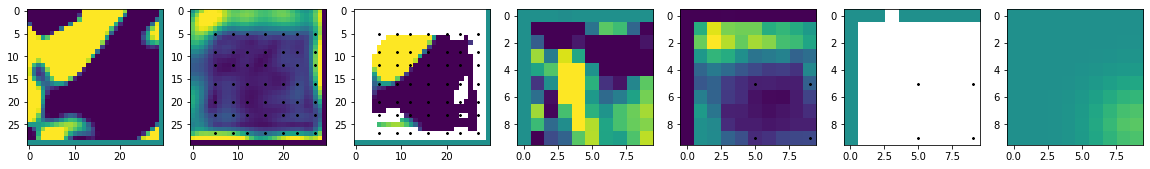

In [32]:
gridX = mInfer.getGridCoord(X[:,1:])

for tsamp in range(0,mInfer.coords.shape[1],10):
    plt.figure(figsize=[20,4])
    
    plt.subplot(1,7,1)
    if tsamp==0: plt.title('source')
    plt.imshow(sourcemean[tsamp,:,:])
    plt.clim([-0.2,0.2])
    
    plt.subplot(1,7,2)  
    if tsamp==0: plt.title('std')
    plt.imshow(np.sqrt(sourcevar[tsamp,:,:]))
    plt.clim([0,0.05])
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('source(conf)')
    vals = sourcemean[tsamp,:,:]
    alphas = np.sqrt(sourcevar[tsamp,:,:])<0.01
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([-0.2,0.2])    
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('conc')
    plt.imshow(concmean[tsamp//scaleby[0],:,:])
    plt.clim([-5,5])
    #plt.colorbar()
    
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('std')
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(np.sqrt(concvar[tsamp//scaleby[0],:,:]))
    #plt.clim([0,0.25])
    #plt.colorbar()
    
    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc(conf)')
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    vals = concmean[tsamp//scaleby[0],:,:]
    alphas = np.sqrt(concvar[tsamp//scaleby[0],:,:])<0.001
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([-10,10])
    #plt.clim([-5,5])
    
    plt.subplot(1,7,7)
    if tsamp==0: plt.title('realconc')
    #plt.scatter(tempgridX[:,1],tempgridX[:,2],1,color='black')
    plt.imshow(realconc[tsamp//scaleby[0],:,:])    
    plt.clim([-10,10])
    ##plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #